First let's set up the environment by installing the required packages and importing them. We'll also setup a connection with the database using the ONE api.

In [ ]:
! pip install ONE-api
! pip install ibllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainbox.io.one import SpikeSortingLoader
from brainbox.plot import peri_event_time_histogram
from brainbox.singlecell import calculate_peths

from ibllib.atlas import AllenAtlas
from one.api import ONE

one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international', silent=True)
ba = AllenAtlas()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 4.7 MB/s 
     |████████████████████████████████| 57 kB 6.6 MB/s 
     |████████████████████████████████| 132 kB 64.8 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 41 kB 272 kB/s 
     |████████████████████████████████| 79 kB 9.7 MB/s 
     |████████████████████████████████| 10.3 MB 38.6 MB/s 
     |████████████████████████████████| 127 kB 49.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.6 MB 28.4 MB/s 
     |████████████████████████████████| 47 kB 6.0 MB/s 
     |████████████████████████████████| 87 kB 8.6 MB/s 
     |████████████

Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/average_template_25.nrrd Bytes: 32998960


100%|██████████| 31.470260620117188/31.470260620117188 [00:03<00:00,  8.67it/s]


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/annotation_25.nrrd Bytes: 4035363


100%|██████████| 3.848422050476074/3.848422050476074 [00:01<00:00,  2.43it/s]


Our first aim is to find recording sessions that recorded from the brain region we're interested in. In this example we'll look for recordings done in the primary visual cortex. Brain regions are found using their Allen atlas acronyms. The primary visual cortex has the acronym "VISp". To find the acronym of your region of interest you can look it up here: http://atlas.brain-map.org/atlas

In [ ]:
len(one.search(dataset=['spikes', 'trials'])) 

373

In [ ]:
ses = one.alyx.rest('insertions', 'list', atlas_acronym="VISp")
print(f'Found {len(ses)} recordings')

Found 373 recordings
ae8787b1-4229-4d56-b0c2-566b61a25b77


Recordings in the IBL dataset have two distinct identifiers: EID and PID. The EID is the identifier of the recording session while the PID is the identifier of a specific probe in a recording session. A single recording session often has two probes. Let's get a list of all the probes that recorded primary visual cortex like so:  

In [ ]:
pids = [i['id'] for i in ses]

Or a list of EIDs like so:

In [ ]:
eids = [i['session'] for i in ses]

Let's now load in the spikes of the first recording of the list.

In [ ]:
PID = pids[0]  # Get the first PID of the list
sl = SpikeSortingLoader(pid=PID, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)

/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-07-08/001/alf/probe01/pykilosort/spikes.amps.npy: 100%|██████████| 29.3M/29.3M [00:00<00:00, 46.6MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-07-08/001/alf/probe01/pykilosort/spikes.clusters.npy: 100%|██████████| 14.6M/14.6M [00:00<00:00, 42.0MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-07-08/001/alf/probe01/pykilosort/spikes.depths.npy: 100%|██████████| 29.3M/29.3M [00:00<00:00, 51.8MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-07-08/001/alf/probe01/pykilosort/spikes.times.npy: 100%|██████████| 29.3M/29.3M [00:00<00:00, 43.2MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-07-08/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 34.3kB/s]
/root

Of course this recording will not only have visual cortex neurons so let's get a list of the neurons that were actually in VISp.

In [ ]:
VISp_neurons = [i for i, acronym in enumerate(clusters['acronym']) if 'VISp' in acronym]
print(f'Found {len(VISp_neurons)} VISp neurons')

Found 97 VISp neurons


We now have the neural activity of the visual cortex neurons in this recording. Let's now get the trial data so that we can align the neural activity to trial events. For this we'll need to convert our PID (which references individual probes) to an EID (which references the entire recording session)

In [ ]:
EID, _ = one.pid2eid(PID)
trials = one.load_object(EID, 'trials')
print(trials.keys())

/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-07-08/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.92k/3.92k [00:00<00:00, 36.2kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-07-08/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.92k/3.92k [00:00<00:00, 26.5kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-07-08/001/alf/_ibl_trials.table.pqt: 100%|██████████| 41.2k/41.2k [00:00<00:00, 307kB/s]


dict_keys(['goCueTrigger_times', 'stimOff_times', 'goCue_times', 'response_times', 'choice', 'stimOn_times', 'contrastLeft', 'contrastRight', 'probabilityLeft', 'feedback_times', 'feedbackType', 'rewardVolume', 'firstMovement_times', 'intervals'])


Let's now plot the neural activity of the first neuron in the list around all the trial onsets.

/usr/local/lib/python3.7/dist-packages/brainbox/plot.py:602: UserWarning: Number of raster traces is greater than 60. This might look bad on the plot.
  warn("Number of raster traces is greater than 60. This might look bad on the plot.")


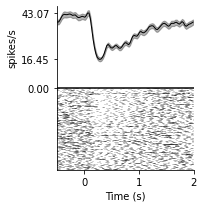

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))
peri_event_time_histogram(spikes.times, spikes.clusters, trials['stimOn_times'],
                          VISp_neurons[0],
                          t_before=0.5, t_after=2,
                          include_raster=True, error_bars='sem', ax=ax,
                          pethline_kwargs={'color': 'black', 'lw': 1},
                          errbar_kwargs={'color': 'black', 'alpha': 0.3},
                          raster_kwargs={'color': 'black', 'lw': 0.3},
                          eventline_kwargs={'lw': 0})
ax.set(ylabel='spikes/s', xlabel='Time (s)')
plt.tight_layout()

For population level analysis you'll want to get a large array of spike counts of all neurons in a certain time window relative to a trial event. In this example we'll get the spike counts of all primary visual cortex neurons 0-300 ms after the onset of a 100% contrast stimulus on the right side. The function will chop up the 300 ms window into 25 ms windows (as set by bin_size).

In [ ]:
peth, spike_counts = calculate_peths(
    spikes.times, spikes.clusters, VISp_neurons,
    trials['stimOn_times'][trials['contrastRight'] == 1],
    pre_time=0, post_time=0.3, bin_size=0.025, smoothing=0)

print('peth["tscale"] contains the timebin centers relative to the event')
print(f'\npeth["means"] is shaped: {peth["means"].shape}')
print('This variable is NxB (neurons x timebins) and contains the mean spike rates over trials')
print(f'\nspike_counts is shaped: {spike_counts.shape}')
print('This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial')

# If you just want all the spikes over the entire 0-300 ms window you can sum like this:
whole_window = np.sum(spike_counts, axis=2)

print(f'\nwhole_window is shaped: {whole_window.shape}')
print('This variable is TxN (trials x neurons) and contains summed spike rates per trial')

peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (97, 12)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (50, 97, 12)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial

whole_window is shaped: (50, 97)
This variable is TxN (trials x neurons) and contains summed spike rates per trial


Some of you will want to find sessions that have recorded from a group of different regions at the same time. This is slightly more complicated but I'll walk you through it. Because now we want to look for simultaneous recordings we'll have to work on the session level and not the insertion level. We'll look for recordings that targeted CA1, thalamic nucleus PO and the anterior cingulate cortex (ACA).

In [ ]:
# First launch three seperate queries looking for recordings in these brain regions
CA1_ses = one.alyx.rest('sessions', 'list', atlas_acronym='CA1')
CA1_eids = [i['id'] for i in CA1_ses]
PO_ses = one.alyx.rest('sessions', 'list', atlas_acronym='PO')
PO_eids = [i['id'] for i in PO_ses]
ACA_ses = one.alyx.rest('sessions', 'list', atlas_acronym='ACA')
ACA_eids = [i['id'] for i in ACA_ses]

# Now check if there are recordings that contain all three regions
eid_list = list(set(CA1_eids) & set(PO_eids) & set(ACA_eids))
print(f'Found {len(eid_list)} recording sessions')


Found 2 recording sessions


Great, we found 2! Now you can use these EIDs to load in the data from those recordings. Bear in mind that the regions we're now interested in are likely to be on two different probes. This example just uses the first recording session from the list.

In [ ]:
# Load in the first probe
sl = SpikeSortingLoader(eid=eid_list[0], pname='probe00', one=one, atlas=ba)
spikes_probe00, clusters_probe00, channels_probe00 = sl.load_spike_sorting()
clusters_probe00 = sl.merge_clusters(spikes_probe00, clusters_probe00, channels_probe00)

# Load in the second probe
sl = SpikeSortingLoader(eid=eid_list[0], pname='probe01', one=one, atlas=ba)
spikes_probe01, clusters_probe01, channels_probe01 = sl.load_spike_sorting()
clusters_probe01 = sl.merge_clusters(spikes_probe01, clusters_probe01, channels_probe01)

Now we can do the same thing as before and plot the neural activity from threse three regions. I already found out for you that CA1 and PO was recorded on probe01 and ACA was recorded on probe00.

/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.26k/5.26k [00:00<00:00, 59.0kB/s]
/usr/local/lib/python3.7/dist-packages/brainbox/plot.py:602: UserWarning: Number of raster traces is greater than 60. This might look bad on the plot.
  warn("Number of raster traces is greater than 60. This might look bad on the plot.")
/usr/local/lib/python3.7/dist-packages/brainbox/plot.py:602: UserWarning: Number of raster traces is greater than 60. This might look bad on the plot.
  warn("Number of raster traces is greater than 60. This might look bad on the plot.")
/usr/local/lib/python3.7/dist-packages/brainbox/plot.py:602: UserWarning: Number of raster traces is greater than 60. This might look bad on the plot.
  warn("Number of raster traces is greater than 60. This might look bad on the plot.")


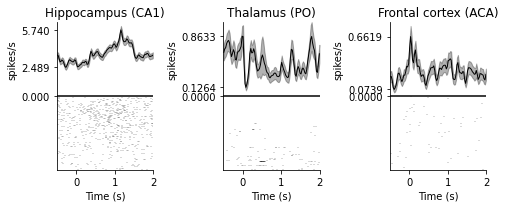

In [ ]:
# Get the neuron indices
CA1_neurons = [i for i, acronym in enumerate(clusters_probe01['acronym']) if 'CA1' in acronym]
PO_neurons = [i for i, acronym in enumerate(clusters_probe01['acronym']) if 'PO' in acronym]
ACA_neurons = [i for i, acronym in enumerate(clusters_probe00['acronym']) if 'ACA' in acronym]

# Load in the trials
trials = one.load_object(eid_list[0], 'trials')

# Plot the figures
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 3))
peri_event_time_histogram(spikes_probe01.times, spikes_probe01.clusters,
                          trials['stimOn_times'], CA1_neurons[0],
                          t_before=0.5, t_after=2,
                          include_raster=True, error_bars='sem', ax=ax1,
                          pethline_kwargs={'color': 'black', 'lw': 1},
                          errbar_kwargs={'color': 'black', 'alpha': 0.3},
                          raster_kwargs={'color': 'black', 'lw': 0.3},
                          eventline_kwargs={'lw': 0})
ax1.set(ylabel='spikes/s', xlabel='Time (s)', title='Hippocampus (CA1)')

peri_event_time_histogram(spikes_probe01.times, spikes_probe01.clusters,
                          trials['stimOn_times'], PO_neurons[0],
                          t_before=0.5, t_after=2,
                          include_raster=True, error_bars='sem', ax=ax2,
                          pethline_kwargs={'color': 'black', 'lw': 1},
                          errbar_kwargs={'color': 'black', 'alpha': 0.3},
                          raster_kwargs={'color': 'black', 'lw': 0.3},
                          eventline_kwargs={'lw': 0})
ax2.set(ylabel='spikes/s', xlabel='Time (s)', title='Thalamus (PO)')

peri_event_time_histogram(spikes_probe00.times, spikes_probe00.clusters,
                          trials['stimOn_times'], ACA_neurons[2],
                          t_before=0.5, t_after=2,
                          include_raster=True, error_bars='sem', ax=ax3,
                          pethline_kwargs={'color': 'black', 'lw': 1},
                          errbar_kwargs={'color': 'black', 'alpha': 0.3},
                          raster_kwargs={'color': 'black', 'lw': 0.3},
                          eventline_kwargs={'lw': 0})
ax3.set(ylabel='spikes/s', xlabel='Time (s)', title='Frontal cortex (ACA)')

plt.tight_layout()
